# 识别验证码

## 生成Captcha验证码

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


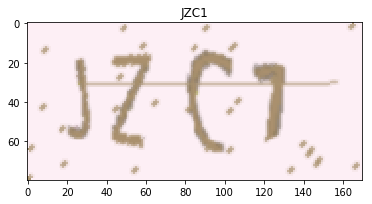

In [2]:
%matplotlib inline
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)
plt.show()

## 生成数据和标签

In [3]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for i in range(4)])
            X[i] = generator.generate_image(random_str)
            
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
            yield X,y

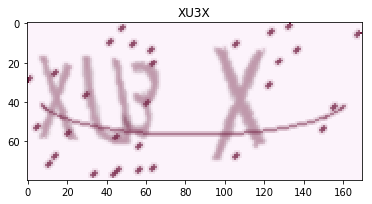

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:, 0]
    return ''.join([characters[x] for x in y])

# test 
X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))
plt.show()

## CNN Model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 166, 32)  9248        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

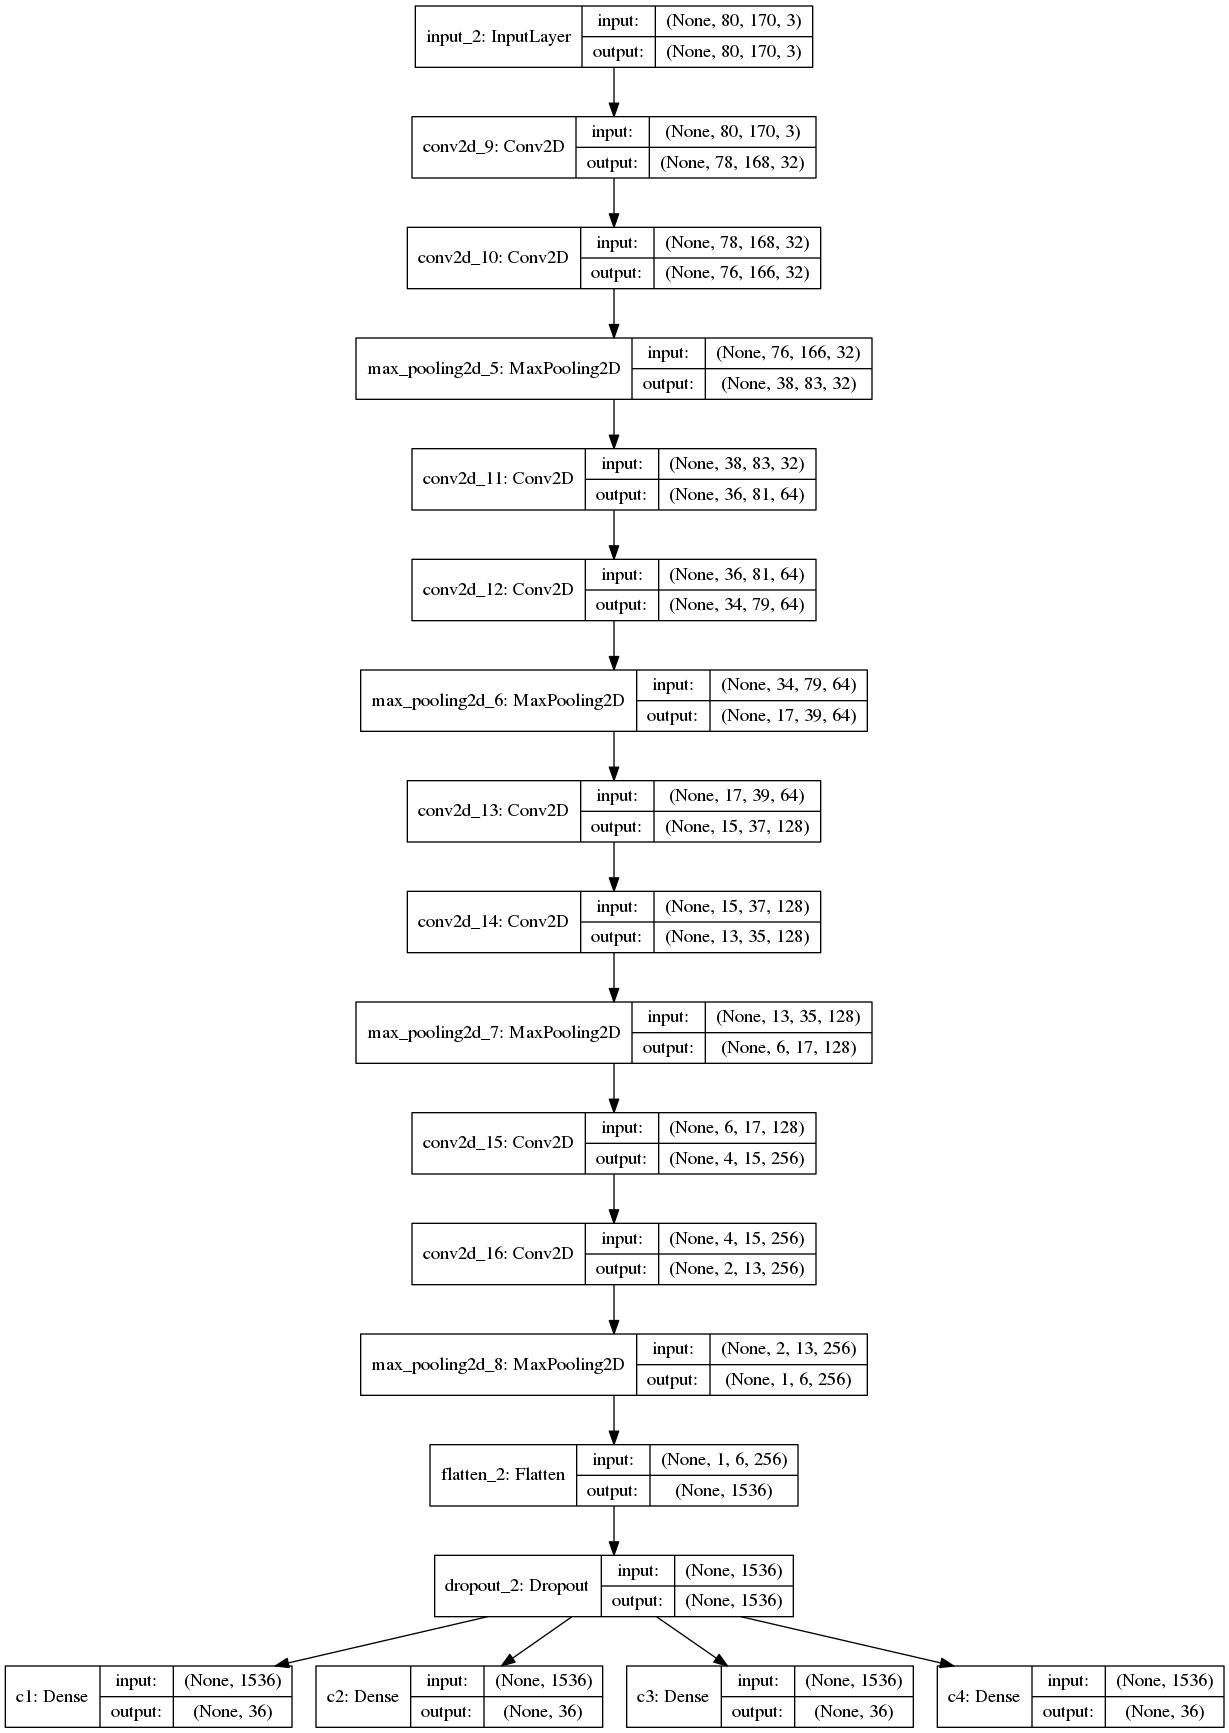

In [6]:
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
from IPython.display import Image

input_tensor = Input((height, width, 3))
x = input_tensor

for i in range(4):
    x = Conv2D(32 * 2 ** i, (3, 3), activation='relu')(x)
    x = Conv2D(32 * 2 ** i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
x = Flatten()(x)
x = Dropout(0.25)(x)

# 多输出模型
x = [Dense(n_class, activation='softmax', name='c%d' %(i + 1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)
model.summary()

plot_model(model, to_file='captcha_cnn_model.png', show_shapes=True)
Image('captcha_cnn_model.png')


### Training

In [7]:
from keras import callbacks

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
cbks = [callbacks.ModelCheckpoint('captcha_model.h5', save_best_only=True)]

history = model.fit_generator(gen(batch_size=32),
                              steps_per_epoch=1600,
                              epochs=5,
                              callbacks=cbks,
                              validation_data=gen(),
                              validation_steps=40)

Epoch 1/5


   1/1600 [..............................] - ETA: 1:34:35 - loss: 19.5580 - c1_loss: 4.4612 - c2_loss: 5.0192 - c3_loss: 5.2073 - c4_loss: 4.8703 - c1_acc: 0.6562 - c2_acc: 0.6562 - c3_acc: 0.6562 - c4_acc: 0.6562

   2/1600 [..............................] - ETA: 1:17:34 - loss: 18.8319 - c1_loss: 4.4972 - c2_loss: 4.7332 - c3_loss: 4.9847 - c4_loss: 4.6168 - c1_acc: 0.3594 - c2_acc: 0.3594 - c3_acc: 0.3281 - c4_acc: 0.3594

   3/1600 [..............................] - ETA: 1:11:24 - loss: 19.7742 - c1_loss: 4.8450 - c2_loss: 5.0023 - c3_loss: 5.0021 - c4_loss: 4.9247 - c1_acc: 0.2500 - c2_acc: 0.2500 - c3_acc: 0.2396 - c4_acc: 0.2500

   4/1600 [..............................] - ETA: 1:08:12 - loss: 20.7490 - c1_loss: 5.0189 - c2_loss: 5.2628 - c3_loss: 5.1367 - c4_loss: 5.3305 - c1_acc: 0.2031 - c2_acc: 0.1953 - c3_acc: 0.1953 - c4_acc: 0.1875

   5/1600 [..............................] - ETA: 1:06:22 - loss: 21.7368 - c1_loss: 5.4255 - c2_loss: 5.5198 - c3_loss: 5.3182 - c4_loss: 5.4733 - c1_acc: 0.1625 - c2_acc: 0.1625 - c3_acc: 0.1688 - c4_acc: 0.1625

   6/1600 [..............................] - ETA: 1:05:04 - loss: 22.8151 - c1_loss: 5.6965 - c2_loss: 5.7751 - c3_loss: 5.5232 - c4_loss: 5.8203 - c1_acc: 0.1406 - c2_acc: 0.1406 - c3_acc: 0.1510 - c4_acc: 0.1354

   7/1600 [..............................] - ETA: 1:04:11 - loss: 23.7293 - c1_loss: 5.9620 - c2_loss: 6.0295 - c3_loss: 5.7416 - c4_loss: 5.9962 - c1_acc: 0.1250 - c2_acc: 0.1250 - c3_acc: 0.1384 - c4_acc: 0.1250

   8/1600 [..............................] - ETA: 1:03:26 - loss: 24.7297 - c1_loss: 6.2242 - c2_loss: 6.2832 - c3_loss: 5.9683 - c4_loss: 6.2541 - c1_acc: 0.1133 - c2_acc: 0.1133 - c3_acc: 0.1289 - c4_acc: 0.1133

   9/1600 [..............................] - ETA: 1:02:54 - loss: 25.7316 - c1_loss: 6.4840 - c2_loss: 6.5364 - c3_loss: 6.2006 - c4_loss: 6.5106 - c1_acc: 0.1042 - c2_acc: 0.1042 - c3_acc: 0.1215 - c4_acc: 0.1042

  10/1600 [..............................] - ETA: 1:02:28 - loss: 26.6843 - c1_loss: 6.6919 - c2_loss: 6.7894 - c3_loss: 6.4368 - c4_loss: 6.7662 - c1_acc: 0.1000 - c2_acc: 0.0969 - c3_acc: 0.1156 - c4_acc: 0.0969

  11/1600 [..............................] - ETA: 1:02:07 - loss: 27.6927 - c1_loss: 6.9535 - c2_loss: 7.0422 - c3_loss: 6.6759 - c4_loss: 7.0211 - c1_acc: 0.0938 - c2_acc: 0.0909 - c3_acc: 0.1108 - c4_acc: 0.0909

  12/1600 [..............................] - ETA: 1:01:46 - loss: 28.6590 - c1_loss: 7.1716 - c2_loss: 7.2949 - c3_loss: 6.9170 - c4_loss: 7.2755 - c1_acc: 0.0911 - c2_acc: 0.0859 - c3_acc: 0.1068 - c4_acc: 0.0859

  13/1600 [..............................] - ETA: 1:01:29 - loss: 29.6703 - c1_loss: 7.4336 - c2_loss: 7.5474 - c3_loss: 7.1599 - c4_loss: 7.5295 - c1_acc: 0.0865 - c2_acc: 0.0817 - c3_acc: 0.1034 - c4_acc: 0.0817

  14/1600 [..............................] - ETA: 1:01:15 - loss: 30.6811 - c1_loss: 7.6581 - c2_loss: 7.7998 - c3_loss: 7.4040 - c4_loss: 7.8191 - c1_acc: 0.0848 - c2_acc: 0.0781 - c3_acc: 0.1004 - c4_acc: 0.0759

  15/1600 [..............................] - ETA: 1:01:02 - loss: 31.6578 - c1_loss: 7.8863 - c2_loss: 8.0521 - c3_loss: 7.6491 - c4_loss: 8.0702 - c1_acc: 0.0833 - c2_acc: 0.0750 - c3_acc: 0.0979 - c4_acc: 0.0729

  16/1600 [..............................] - ETA: 1:00:49 - loss: 32.6069 - c1_loss: 8.0860 - c2_loss: 8.3044 - c3_loss: 7.9266 - c4_loss: 8.2899 - c1_acc: 0.0840 - c2_acc: 0.0723 - c3_acc: 0.0938 - c4_acc: 0.0723

  17/1600 [..............................] - ETA: 1:00:40 - loss: 33.5925 - c1_loss: 8.3215 - c2_loss: 8.5566 - c3_loss: 8.1714 - c4_loss: 8.5429 - c1_acc: 0.0827 - c2_acc: 0.0699 - c3_acc: 0.0919 - c4_acc: 0.0699

  18/1600 [..............................] - ETA: 1:00:31 - loss: 34.5525 - c1_loss: 8.5308 - c2_loss: 8.8088 - c3_loss: 8.4170 - c4_loss: 8.7959 - c1_acc: 0.0833 - c2_acc: 0.0677 - c3_acc: 0.0903 - c4_acc: 0.0677

  19/1600 [..............................] - ETA: 1:00:23 - loss: 35.5705 - c1_loss: 8.7975 - c2_loss: 9.0610 - c3_loss: 8.6633 - c4_loss: 9.0487 - c1_acc: 0.0806 - c2_acc: 0.0658 - c3_acc: 0.0888 - c4_acc: 0.0658

  20/1600 [..............................] - ETA: 1:00:17 - loss: 36.5623 - c1_loss: 9.0376 - c2_loss: 9.3131 - c3_loss: 8.9101 - c4_loss: 9.3014 - c1_acc: 0.0797 - c2_acc: 0.0641 - c3_acc: 0.0875 - c4_acc: 0.0641

KeyboardInterrupt: 

### Display Results

In [ ]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics), '-o')
    plt.plot(history.history.get(val_metrics), '-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
plot_train_history(history, 'loss', 'val_loss')

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plot_train_history(history, 'c1_acc', 'val_c1_acc')

plt.subplot(2, 2, 2)
plot_train_history(history, 'c2_acc', 'val_c2_acc')

plt.subplot(2, 2, 3)
plot_train_history(history, 'c3_acc', 'val_c3_acc')

plt.subplot(2, 2, 4)
plot_train_history(history, 'c4_acc', 'val_c4_acc')

plt.show()

### Evaluation

In [ ]:
from keras.models import load_model

del model
model = load_model('captcha_model.h5')

X, y = next(gen(1))
y_pred = model.predict(X)

plt.title('real: %s \n pred: %s' %(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.show()


### Accuracy

In [ ]:
from tqdm import tqdm

def evaluate(model, batch_num=20):
    batch_acc = 0
    batch_count = 0
    
    generator = gen()
    
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        
        for i in range(len(y_pred)):
            batch_count += 1
            if np.array_equal(y_true[i], y_pred[i]):
                batch_acc += 1
                
    return batch_acc / batch_count
    
    
evaluate(model)